_This report is available in both file extensions of .pdf and .ipynb_

# Improving movie rating prediction

Question: How can we improve the movie rating prediction?
In the exploration part of the assignment, we intend to find ways to improve the rating prediction model. On the way of sharpening the prediction, we also prepared the dataset to subsets of test set and training set. We then use the test set to test to model trained by the training set. After that, we sharpened the model to better predict the movie rating. Therefore, the test is done twice—one for the original prediction, and another for the sharpened prediction. We then have the test results of the two for comparison. CSV files and the visualization of the findings will also be presented. 

## 1. Importing necessary libraries 

We used of a list of libraries that allows us to perform actions without spending extensive of time to write our own code. _pandas_ is used for loading and reading CSV tables, and matplotlib is used to visualize our findings.

In [48]:
from typing import TextIO, List, Union, Dict, Tuple
import doctest
from sentiment import *
from random import shuffle
import csv
import sys
import math

import pandas as pd
import matplotlib.pyplot as plt

## 2. Partitioning dataset into "test" and "training" subsets
We split the given dataset into two subsets for testing and training with the ratio of 20 : 80. The ratio is custimizable by changing the test_size variable of partition_dataset function. The dataset is shuffled before the splitting to ensure the randomness of each sample. However, the ratio of the movie rating scores is kept representative of the population dataset.

In [49]:
def partition_dataset(file:TextIO, file_name:str, test_size:float) -> Dict:
    """Precondition: test_size > 0.0 and < 1.0 (one decimal)
    Create two datasets sorted randomly from the original. The test_dataset has the size
    requested in test_size, and the trainin_dataset has the remaining size.
    Print a message e.g., "The files: test_data.txt and training_data.txt were created",
    and return a dictionary e.g., {'test': 'test_data.txt', 'training': 'training_data.txt'}
    
    >>> file_names = partition_dataset(open('full.txt', 'r'), 'data', 0.2)
    The files: test_data.txt and training_data.txt were created
    >>> file_names
    {'test': 'test_data.txt', 'training': 'training_data.txt'}
    """
    all_reviews = file.readlines()
    shuffle(all_reviews)
    rating_counts = {}
    test_set = []
    training_set = []
    for review in all_reviews:
        if review[0] in rating_counts:
            rating_counts[review[0]].append(review)
        else:
            rating_counts[review[0]] = [review]
    for rating, reviews in rating_counts.items():
        length_of_test_data = round(len(reviews) * (test_size))
        test_set.extend(reviews[:length_of_test_data])
        training_set.extend(reviews[length_of_test_data:])
    test_file_name = "test_" + file_name + ".txt"
    training_file_name = "training_" + file_name + ".txt"

    with open(test_file_name, 'w') as test_file:
        for row in test_set:
            test_file.write(row)

    with open(training_file_name, 'w') as training_file:
        for row in training_set: 
            training_file.write(row)

    print('The files: '+ test_file_name + ' and ' + training_file_name + ' were created')
    return {'test':test_file_name, 'training':training_file_name}

## 3. Sharpening the model
In the many ways we have tried, we found that removing the given common words and neutral words improves the prediction model. We removed the common words from the kss dictionary because they may dilute the impact of more context specific words.

In [50]:
def sharpen_model(common_words_file:TextIO ,kss: Dict[str, List[int]])->Dict:
    """Sharpen the prediction model by removing neutral words and common words from kss dictionary. 
    Return kss_sharpened as the sharpened kss dictionary.
    """
    common_words_file = common_words_file.read().splitlines()
    kss_sharpened = {}
    for word, value in kss.items():
        if (judge(value[0]/value[1]) != 'neutral') or (word not in common_words_file):
            kss_sharpened[word] = value
    return kss_sharpened    


## 4. Evaluating the models
The following functions gets four values that will be used to compare the original prediction model and the sharpen prediction model. 

* **Predicted Sentiment Score:** A sentiment of a statement(review) determined by the model.

* **Predicted Movie Rating:** Because the PSS is ratio value and the movie rating is ordinal value, the predict_movie_rating will use the PSS score to predict a movie rating in ordinal value. 

* **The absolute error:** The absolute error is the absolute difference between PSS and the actual rating

* **Closeness evaluation:** is_close_eval is another way to tell us if a PSS is considered close to the actual rating. Here, we put the threshold as 0.05. The values of the actual score and the PSS are considered closed if the difference is smaller than 0.05.

Then, report_errors will return a list of above four values for a review. Lastly, the report_mean_error function will return the mean error of all the errors between the actual scores and the predicted scores.

In [51]:
def predict_movie_rating(pss_score: float)->int:
    """ Get the Predicted Sentiment Score and use it to predict the movie rating from a review statement. 
    >>> predict_movie_rating(2.8)
    3
    >>> predict_movie_rating(1.2)
    1
    """
    return int(round(pss_score))

def is_close_eval(pss_score, actual_rating)-> bool:
    """ Get the difference between the actual movie rating and the Predicted Sentiment Score and determine
    if the difference is larger than 0.05. If the difference is larger than 0.05, return False. 
    If the difference is smaller than or equals to 0.05, return True.
    >>> is_close_eval(2.05, 2)
    True
    >>> is_close_eval(2.02, 2)
    True
    >>> is_close_eval(3.05, 2)
    False
    """
    return math.isclose(pss_score, actual_rating, abs_tol=0.05)

def report_errors(review: str, kss: Dict[str, List[int]])->List:
    """ Return a list of scores for each review in the follow order: 
    1. the Predicted Sentiment Score, 
    2. the predicted movie rating, 
    3. the absolute difference between PSS and the actual rating, 
    4. a boolean value returned by is_close_eval()
    """
    actual_rating = float(review[0])
    absolute_errors = []
    pss_score = statement_pss(review, kss)
    review_scores = []
    if pss_score != None:
        is_close_val = is_close_eval(pss_score, actual_rating)
        absolute_error = round((abs(float(pss_score) - actual_rating)), 2)
        absolute_errors.append(absolute_error)
        review_scores = [pss_score, predict_movie_rating(pss_score), absolute_error, is_close_val]
        return review_scores

def report_mean_error(absolute_errors:List[float]):
    """ Return the mean abosolute error of a given list of error values.
    >>> report_mean_error([1.56, 0.24, 0.69])
    0.83
    """
    if len(absolute_errors) != 0:
        mean_absolute_error = round(sum(absolute_errors)/len(absolute_errors), 5)
        return mean_absolute_error

## 5. Compare the models
After retrieving the four values for each model by the previous step, we can now use them to compare the original model and the sharpened model.

In [52]:
def compare_pss_models(test_file:TextIO, common_words_file:TextIO ,kss: Dict[str, List[int]], name_datasets) -> Dict:
    """Create a csv dataset with the comparison of the scores given by the kss model and the original ones. 
    Print the message "The file: reviews_comparison.csv was created" and return a dictionary with the 
    Mean_Absolute_Error(MAE) and Mean_Absolute_Error(MAE)_Sharpened of the dataset e.g., 
    {'Mean_Absolute_Error(MAE)': 1.00225, 'Mean_Absolute_Error(MAE)_Sharpened': 0.96186}
    >>> file1 = open('full.txt', 'r')
    >>> file2 = open('most_common_english_words.txt', 'r')
    >>> kss = extract_kss(file1)
    >>> testing_result = compare_pss_models(file1, file2, kss, 'data')
    The file: reviews_data.csv was created
    >>> file1.close()
    >>> file2.close()
    """
    scores_comparison = []
    original_report_list = []
    sharpened_report_list = []
    original_absolute_errors = []
    sharpened_absolute_errors = []
    test_reviews = test_file.readlines()
    
    ### Sharpend kss by removing all common words
    kss_sharpened = sharpen_model(common_words_file ,kss)
   
    # Iterate over each review in order to get predicted rating and MAE for kss and the sharpened version of kss          
    for review in test_reviews:
        statement = review[1:].strip()
        original_report = report_errors(review, kss)
        sharpened_report = report_errors(review, kss_sharpened)
        if statement_pss(review, kss) != None and statement_pss(review, kss_sharpened):
            original_report_list.append(original_report)
            sharpened_report_list.append(sharpened_report)
            original_absolute_errors.append(original_report[2])
            sharpened_absolute_errors.append(sharpened_report[2])
            scores_comparison.append([statement, review[0], 
                                      round(original_report[0],2), original_report[1], original_report[2], original_report[3], 
                                      round(sharpened_report[0],2), sharpened_report[1],sharpened_report[2], sharpened_report[3]])
            
    # Get mean absolute errors from the original and the sharpened model        
    mean_absolute_error = report_mean_error(original_absolute_errors)
    mean_absolute_error_sharpened = report_mean_error(sharpened_absolute_errors)

    # Save all reviews with their predicted scores and MAE using kss and kss_sharpened     
    with open('reviews_'+ name_datasets + '.csv', mode ='w') as comparison_file:
        comparison_writer = csv.writer(comparison_file, delimiter=",", quotechar='"', quoting = csv.QUOTE_MINIMAL)
        comparison_writer.writerow([("Mean Absolute Error(MAE): " + str(mean_absolute_error)), 
                                    ("Mean Absolute Error(MAE)   Sharpened: " + str(mean_absolute_error_sharpened))])
        comparison_writer.writerow(["-","-","-","-","-"])
        comparison_writer.writerow(["Review", "Actual Rating", 
                                    "PSS Score", "Predicted Rating", "Absolute Error", "Evaluation Result", 
                                    "PSS Score Sharpened", "Predicted Rating Sharpened","Absolute Error Sharpened", "Evaluation Result Sharpened"])
        for row in scores_comparison:
            comparison_writer.writerow(row)

    print('The file: ' + 'reviews_'+ name_datasets + '.csv' + ' was created')
    return {"Mean_Absolute_Error(MAE)": mean_absolute_error,"Mean_Absolute_Error(MAE)_Sharpened":mean_absolute_error_sharpened}


## 6. Open the datasets and their subsets to execute the comparison

This function runs previous functions in sequence. In the end, the **Mean Absolute Error(MAE)** of both original prediciton model and sharpened prediction model are returned as a dictionary. This function also allows to run the model on more than one dataset. This allows us to compare not only the difference of the mean absolute error between the datasets of three different sizes.

In [53]:
def execute_test(datasets: Dict[str, str], partition_size):
    """Precondition: the dictionary should have the form {name_dataset:dataset} e.g., {"small":"small.txt","medium":"medium.txt","full":"full.txt"}  
    Run compare_pss_models function for various datasets.
    """
    for name in datasets:
        with open(datasets[name], 'r') as file:
            file_names = partition_dataset(file, name, partition_size)
        with open(file_names['training'], 'r') as training_file:
                kss = extract_kss(training_file)  
        with open(file_names['test'], 'r') as test:
            with open(most_common_words) as common_words_file:
                testing_result = compare_pss_models(test, common_words_file, kss, name)
                

## 7. Calling the function and test the code by doctest.testmond()


Here, we specify that only when this module is run as a script, we call excute_test() and do the testing by doctest.testmod()

In [54]:
if __name__ == "__main__":
    #Create a dictionary containing diferent datasets, in order to compare accuracies among each other.
    datasets =  {
        "small"     : "small.txt",
        "medium"    : "medium.txt",
        "full"      : "full.txt"
    }        
    
    most_common_words = "most_common_english_words.txt"
    execute_test(datasets, 0.1)
    doctest.testmod()

The files: test_small.txt and training_small.txt were created
The file: reviews_small.csv was created
The files: test_medium.txt and training_medium.txt were created
The file: reviews_medium.csv was created
The files: test_full.txt and training_full.txt were created
The file: reviews_full.csv was created


# Analysing the results
Before the analysis, we have to load and read the result CSV files. We have done so for the datasets in three different sizes. We will provide analysis individually.

## The "full" dataset 

### The results in CSV table

In [55]:
evaluated_reviews_full = pd.read_csv('reviews_full.csv', header=2)
evaluated_reviews_full.head()

,Review,Actual Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,Enthusiastically taking up the current teen mo...,3,2.33,2,0.67,False,2.61,3,0.39,False
1,Aniston has at last decisively broken with her...,3,2.23,2,0.77,False,2.37,2,0.63,False
2,A very funny romantic comedy about two skittis...,3,2.18,2,0.82,False,2.24,2,0.76,False
3,"Initially gripping , eventually cloying POW dr...",3,2.10,2,0.90,False,2.01,2,0.99,False
4,"The movie itself is far from disappointing , o...",3,2.02,2,0.98,False,2.03,2,0.97,False


### The Mean Absolute Errors
In the full dataset, the Mean Absolute Error(MAE) of the sharpened model is usually lower than the original MAE.

In [56]:
pd.read_csv('reviews_full.csv', nrows=0)

,Mean Absolute Error(MAE): 1.00473,Mean Absolute Error(MAE) Sharpened: 0.9294


### The number of predictions that are significantly close to the actual rating
However, the number of close predictions is lowered.

In [57]:
evaluated_reviews_full["Evaluation Result"].value_counts()

False    806
True      33
Name: Evaluation Result, dtype: int64

In [58]:
evaluated_reviews_full["Evaluation Result Sharpened"].value_counts()

False    820
True      19
Name: Evaluation Result Sharpened, dtype: int64

## The "medium" dataset

In [59]:
evaluated_reviews_medium = pd.read_csv('reviews_medium.csv', header=2)
evaluated_reviews_medium.head()

,Review,Actual Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,Not everyone will welcome or accept The Trials...,3,2.00,2,1.00,False,1.94,2,1.06,False
1,A captivatingly quirky hybrid of character por...,3,2.46,2,0.54,False,2.92,3,0.08,False
2,Jackson and co have brought back the value and...,3,1.99,2,1.01,False,1.94,2,1.06,False
3,Nothing can detract from the affection of that...,3,1.95,2,1.05,False,1.71,2,1.29,False
4,"The picture runs a mere 84 minutes , but it 's...",3,1.75,2,1.25,False,1.41,1,1.59,False


### The Mean Absolute Errors
In the medium dataset, the Mean Absolute Error(MAE) of the sharpened model is usually lower than the original MAE.

In [60]:
pd.read_csv('reviews_medium.csv', nrows=0)

,Mean Absolute Error(MAE): 1.11412,Mean Absolute Error(MAE) Sharpened: 1.09216


### The number of predictions that are significantly close to the actual rating
The number of close predictions is sometimes raised or lowered.

In [61]:
evaluated_reviews_medium["Evaluation Result"].value_counts()

False    48
True      3
Name: Evaluation Result, dtype: int64

In [62]:
evaluated_reviews_medium["Evaluation Result Sharpened"].value_counts()

False    49
True      2
Name: Evaluation Result Sharpened, dtype: int64

## The "small" dataset

In [63]:
evaluated_reviews_small = pd.read_csv('reviews_small.csv', header=2)
evaluated_reviews_small.head()

,Review,Actual Rating,PSS Score,Predicted Rating,Absolute Error,Evaluation Result,PSS Score Sharpened,Predicted Rating Sharpened,Absolute Error Sharpened,Evaluation Result Sharpened
0,The underworld urban angst is derivative of Ma...,3,2.29,2,0.71,False,2.56,3,0.44,False
1,As an entertainment destination for the genera...,1,1.84,2,0.84,False,1.62,2,0.62,False


### The Mean Absolute Errors
In the small dataset, the Mean Absolute Error(MAE) of the sharpened model is sometimes lower than the original MAE. We find the small dataset has more unreliable results in the MAE values.

In [64]:
pd.read_csv('reviews_small.csv', nrows=0)

,Mean Absolute Error(MAE): 0.775,Mean Absolute Error(MAE) Sharpened: 0.53


### The number of predictions that are significantly close to the actual rating
The number of close predictions is almost always unchanged

In [65]:
evaluated_reviews_small["Evaluation Result"].value_counts()

False    2
Name: Evaluation Result, dtype: int64

In [66]:
evaluated_reviews_small["Evaluation Result Sharpened"].value_counts()

False    2
Name: Evaluation Result Sharpened, dtype: int64

## Visualizing the results
### PSS scores distribution from original model and sharpened model in all datasets
Now, we need to plot a histogram which is a good tool to interpret the distribution of the reviews. The result had shown us that the PSS scores in full and medium datasets are more affected than the small dataset by the sharpened model. We can also see that the sharpened models redistribute the scores by increasing the number of scores in the non-neutral zone.

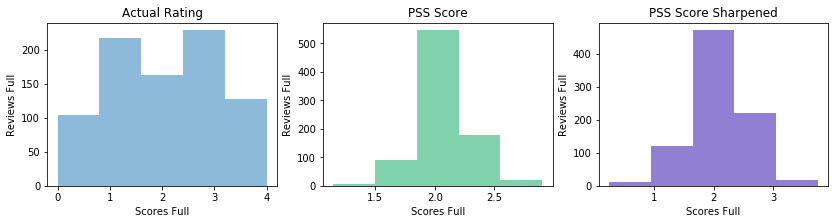

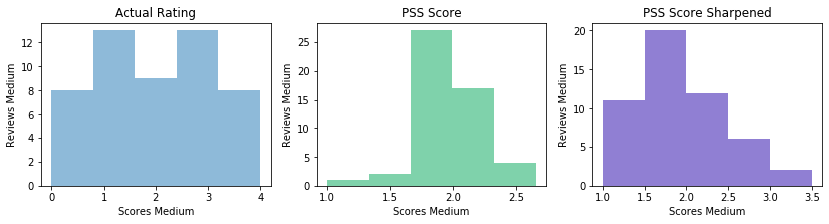

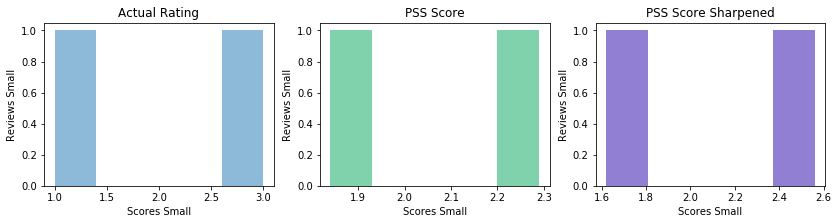

In [67]:
#Distributions for Full dataset
plots_size = (14,3)
plt.figure(1, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_full['Actual Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Actual Rating')
original.set_xlabel('Scores Full')
original.set_ylabel('Reviews Full')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_full['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Full')
predicted.set_ylabel('Reviews Full')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_full['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Full')
predicted_sharpen.set_ylabel('Reviews Full')

#Distributions for Medium dataset
plots_size = (14,3)
plt.figure(2, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_medium['Actual Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Actual Rating')
original.set_xlabel('Scores Medium')
original.set_ylabel('Reviews Medium')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_medium['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Medium')
predicted.set_ylabel('Reviews Medium')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_medium['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Medium')
predicted_sharpen.set_ylabel('Reviews Medium')

#Distributions for Small dataset
plots_size = (14,3)
plt.figure(3, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_small['Actual Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Actual Rating')
original.set_xlabel('Scores Small')
original.set_ylabel('Reviews Small')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_small['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Small')
predicted.set_ylabel('Reviews Small')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_small['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Small')
predicted_sharpen.set_ylabel('Reviews Small')

plt.show()

### Distribution of PSS score and  distribution of Predicted rating in "full" datasets 
By visualizing the distribution of PSS score and the disctribution of predicted rating in the same dataset, we can see the of PSS scores that are close to the neutral zone are categorized into "2", and "2" is the mode for both distributions. Compare to the actual rating distribution, we conclude that the prediction model's sentiment has much room for improvement. Ways of sharpening the sentiment to make the prediction less likely to fall into the neutral zone.

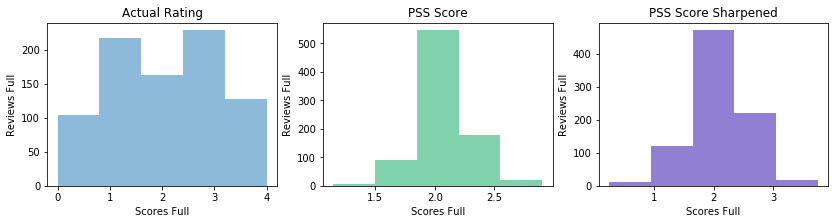

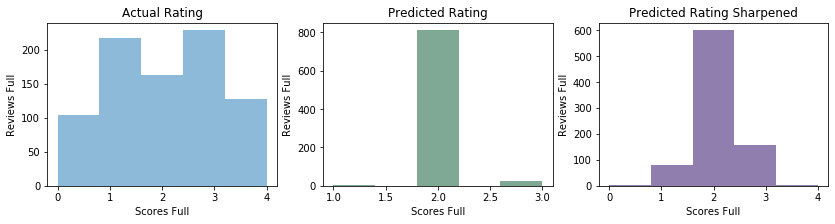

In [73]:
#Distributions for Full dataset
plots_size = (14,3)
plt.figure(1, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_full['Actual Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Actual Rating')
original.set_xlabel('Scores Full')
original.set_ylabel('Reviews Full')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_full['PSS Score'], bins=5, alpha=0.5, label='PSS', color='#00A658')
predicted.set_title('PSS Score')
predicted.set_xlabel('Scores Full')
predicted.set_ylabel('Reviews Full')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_full['PSS Score Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#2300A8')
predicted_sharpen.set_title('PSS Score Sharpened')
predicted_sharpen.set_xlabel('Scores Full')
predicted_sharpen.set_ylabel('Reviews Full')

#Distributions for Medium dataset
plots_size = (14,3)
plt.figure(2, figsize=plots_size)
#Subplot 1
original = plt.subplot(131)
original.hist(evaluated_reviews_full['Actual Rating'], bins=5, alpha=0.5, label='PSS')
original.set_title('Actual Rating')
original.set_xlabel('Scores Full')
original.set_ylabel('Reviews Full')
#Subplot 2
predicted = plt.subplot(132)
predicted.hist(evaluated_reviews_full['Predicted Rating'], bins=5, alpha=0.5, label='PSS', color='#00542d')
predicted.set_title('Predicted Rating')
predicted.set_xlabel('Scores Full')
predicted.set_ylabel('Reviews Full')
#Subplot 3
predicted_sharpen = plt.subplot(133)
predicted_sharpen.hist(evaluated_reviews_full['Predicted Rating Sharpened'], bins=5, alpha=0.5, label='PSS Sharpen', color='#23005e')
predicted_sharpen.set_title('Predicted Rating Sharpened')
predicted_sharpen.set_xlabel('Scores Full')
predicted_sharpen.set_ylabel('Reviews Full')

plt.show()